In [86]:
import numpy as np

In [87]:
def Pi(x: np.array):
    """
    Converts homogeneous to inhomogeneous coordinates
    Args:
        x (np.array) homogeneous coordinate

    Return:
        np.array converted inhomogeneous coordinate
    """

    return x[:-1] / x[-1]


def Piinv(x: np.array):
    """
    Converts inhomogeneous to homogeneous coordinates

    Args:
        x (np.array) inhomogeneous coordinate

    Return:
        np.array converted homogeneous coordinate
    """
    if x.ndim == 1:
        return np.concatenate((x, np.ones(1)))
    return np.vstack((x, np.ones((1, x.shape[1]))))

In [88]:
def skew(x: np.array):
    """
    This function returns a numpy array with the skew symmetric cross product matrix for vector.
    the skew symmetric cross product matrix is defined such that
    np.cross(a, b) = np.dot(skew(a), b)
    https://stackoverflow.com/questions/36915774/form-numpy-array-from-possible-numpy-array

    Args:
        x (np.array): 1x3 matrix

    Return:
        s (np.array): 3x3 skew symmetrix matrix for cross product
    """
    vector = x.ravel()
    s = np.asarray(
        [
            [0, -vector[2], vector[1]],
            [vector[2], 0, -vector[0]],
            [-vector[1], vector[0], 0],
        ]
    )
    return s

## Ex 4.1

In [89]:
R = np.asarray([[np.sqrt(0.5), -np.sqrt(0.5), 0], [np.sqrt(0.5), np.sqrt(0.5), 0], [0, 0, 1]])
t = np.asarray([0, 0, 10]).reshape(3, 1)
K = np.asarray([[1000, 0, 960], [0, 1000, 540], [0, 0, 1]])
P = K @ np.concatenate((R, t), axis=1)
P

array([[ 7.07106781e+02, -7.07106781e+02,  9.60000000e+02,
         9.60000000e+03],
       [ 7.07106781e+02,  7.07106781e+02,  5.40000000e+02,
         5.40000000e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         1.00000000e+01]])

In [90]:
from itertools import product

# Generate all combinations of (i, j, k)
world_points = np.asarray(list(product([0, 1], repeat=3)))

print("All 8 world_points:")
print(world_points)
world_points = Piinv(world_points.reshape(3, -1))
world_points

All 8 world_points:
[[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]


array([[0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 1., 0., 0., 1.],
       [0., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.]])

In [91]:
image_points = P @ world_points
image_points.shape

(3, 8)

## Ex 4.2

In [94]:
def pest(Q: np.array, q: np.array):
    """
    Find projection matrix using DLT
    Args:
        Q (np.array): homogeneous real world points
        q (np.array): homogeneous image points

    Return:
        P (np.array): projection matrix from real to image
    """
    # Ensure Q and q are in homogeneous coordinates (3xN)
    A = []
    if Q.shape[0] == 2:
        Q = Piinv(Q)
    if q.shape[0] == 2:
        q = Piinv(q)
    num_points = Q.shape[1]
    for i in range(num_points):
        q_no_scale = q[:, i] / q[-1][i]
        q_skew = skew(q_no_scale.reshape(1, 3))
        B_i = np.kron(Q[:, i].T, q_skew)
        A.append(B_i)
    B = np.vstack(A)
    U, S, VT = np.linalg.svd(B)
    ## Important
    P = VT[-1, :].reshape(4, 3).T
    return P

In [120]:
calculated = pest(world_points, image_points)
scaled = calculated * np.linalg.norm(P) / np.linalg.norm(calculated)
scaled, P

(array([[ 7.07106781e+02, -7.07106781e+02,  9.60000000e+02,
          9.60000000e+03],
        [ 7.07106781e+02,  7.07106781e+02,  5.40000000e+02,
          5.40000000e+03],
        [ 2.40289311e-12,  4.23418666e-12,  1.00000000e+00,
          1.00000000e+01]]),
 array([[ 7.07106781e+02, -7.07106781e+02,  9.60000000e+02,
          9.60000000e+03],
        [ 7.07106781e+02,  7.07106781e+02,  5.40000000e+02,
          5.40000000e+03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          1.00000000e+01]]))

In [119]:
np.linalg.norm(P - scaled) / world_points.shape[1]

6.931622180024931e-10

## Checkerboard calibration

In [125]:
def checkerboard_points(n: int, m: int):
    """
    Generate a checkerboard of points from dimensions n and m
    Args:
        n (int): number of rows
        m (int): number of cols

    Return:
        board (np.array): checkerboard points
    """
    A = []
    for i in range(n):
        for j in range(m):
            A.append([i - (n-1)//2, j - (m-1)//2, 0])
    board = np.vstack(A).T
    return board
checkerboard =  checkerboard_points(4, 4)
checkerboard.shape, checkerboard , checkerboard.T


((3, 16),
 array([[-1, -1, -1, -1,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2],
        [-1,  0,  1,  2, -1,  0,  1,  2, -1,  0,  1,  2, -1,  0,  1,  2],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]),
 array([[-1, -1,  0],
        [-1,  0,  0],
        [-1,  1,  0],
        [-1,  2,  0],
        [ 0, -1,  0],
        [ 0,  0,  0],
        [ 0,  1,  0],
        [ 0,  2,  0],
        [ 1, -1,  0],
        [ 1,  0,  0],
        [ 1,  1,  0],
        [ 1,  2,  0],
        [ 2, -1,  0],
        [ 2,  0,  0],
        [ 2,  1,  0],
        [ 2,  2,  0]]))

## Ex 4.4

In [130]:
from scipy.spatial.transform import Rotation

In [128]:
n, m = 10, 20
checkerboard = checkerboard_points(n, m)

min_x = np.min(checkerboard[0, :])
max_x = np.max(checkerboard[0, :])
min_y = np.min(checkerboard[1, :])
max_y = np.max(checkerboard[1, :])

corners = np.array([
    [min_x, min_y, 0],  # Top-left
    [min_x, max_y, 0],  # Top-right
    [max_x, min_y, 0],  # Bottom-left
    [max_x, max_y, 0]   # Bottom-right
])
Q_omegas = corners.T
Q_omegas.shape, Q_omegas

((3, 4),
 array([[-4, -4,  5,  5],
        [-9, 10, -9, 10],
        [ 0,  0,  0,  0]]))

In [138]:
Q_a = Rotation.from_euler('xyz', [np.pi/10, 0, 0]).as_matrix() @ checkerboard
Q_b = Rotation.from_euler("xyz", [0, 0, 0]).as_matrix() @ checkerboard
Q_c = Rotation.from_euler("xyz", [-np.pi / 10, 0, 0]).as_matrix() @ checkerboard
Q_a.shape, Q_b.shape, Q_c.shape

((3, 200), (3, 200), (3, 200))

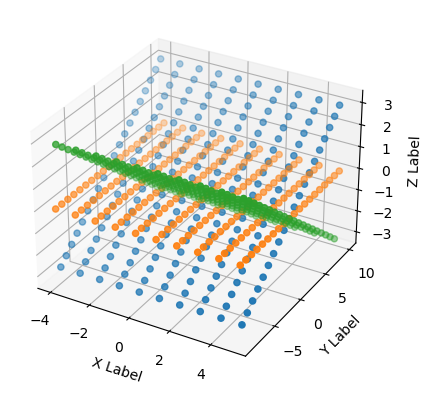

In [140]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(Q_a[0], Q_a[1], Q_a[2])
ax.scatter(Q_b[0], Q_b[1], Q_b[2])
ax.scatter(Q_c[0], Q_c[1], Q_c[2])

ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_zlabel("Z Label")

plt.show()